### **BCCA re-implementation**

In [0]:
# have to install first every time
# install pyro in case here
!pip install pyro-ppl

#### **Tensor Shape review**
- https://pyro.ai/examples/tensor_shapes.html
  - Distribution .sample().shape == batch_shape + event_shape.
    - Indices over .batch_shape denote conditionally independent random variables.
    - Indices over .event_shape denote dependent random variables (ie one draw from a distribution). 
    - the .log_prob() method only produces a single number for each event of shape .event_shape. Thus the total shape of .log_prob() is .batch_shape
  - Distribution .log_prob(x).shape == batch_shape (but not event_shape!).
  - Use .expand() to draw a batch of samples, or rely on plate to expand automatically.
  - Use my_dist.to_event(1) to declare a dimension as dependent.
  - Use with pyro.plate('name', size): to declare a dimension as conditionally independent.
  - All dimensions must be declared either dependent or conditionally independent. 
  - Try to support batching on the left. This lets Pyro auto-parallelize.

  - Note that the Distribution.sample() method also takes a sample_shape parameter that indexes over independent identically distributed (iid) random varables, so that

    ```
    x2 = d.sample(sample_shape)
    assert x2.shape == sample_shape + batch_shape + event_shape
    ```
  - For example univariate distributions have empty event shape (because each number is an independent event). Distributions over vectors like MultiNormal have len(event_shape) == 1. Distributions over matrices like InverseWishart have len(event_shape) == 2.

In [0]:
import os
import torch
import pyro
from torch.distributions import constraints
from pyro.distributions import Bernoulli, Categorical, MultivariateNormal, Normal
from pyro.distributions.util import broadcast_shape
from pyro.infer import Trace_ELBO, TraceEnum_ELBO, config_enumerate
import pyro.poutine as poutine
from pyro.optim import Adam

smoke_test = ('CI' in os.environ)
# We'll ue this helper to check our models are correct.
def test_model(model, guide, loss):
    pyro.clear_param_store()
    loss.loss(model, guide)

In [0]:
# The simplest distribution shape is a single univariate distribution.
d = Bernoulli(0.5)
assert d.batch_shape == ()
assert d.event_shape == ()
x = d.sample()
assert x.shape == ()
assert d.log_prob(x).shape == ()

In [0]:
# Distributions can be batched by passing in batched parameters.
d = Bernoulli(0.5 * torch.ones(3,4)) # conditionally independent random variables
assert d.batch_shape == (3, 4)
assert d.event_shape == () # no dependent variables
x = d.sample()
assert x.shape == (3, 4) # consistent with d shape
assert d.log_prob(x).shape == (3, 4)

In [5]:
# Another way to batch distributions is via the .expand() method. 
# This only works if parameters are identical along the leftmost dimensions.
d = Bernoulli(torch.tensor([0.1, 0.2, 0.3, 0.4])).expand([3, 4])
assert d.batch_shape == (3, 4)
assert d.event_shape == ()
x = d.sample()
assert x.shape == (3, 4)
assert d.log_prob(x).shape == (3, 4)
print(x)

tensor([[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 1.]])


In [6]:
# Multivariate distributions have nonempty .event_shape. For these distributions, the shapes of .sample() and .log_prob(x) differ:
d = MultivariateNormal(torch.zeros(3), torch.eye(3, 3))
assert d.batch_shape == ()
assert d.event_shape == (3,)
x = d.sample()
assert x.shape == (3,)            # == batch_shape + event_shape
assert d.log_prob(x).shape == ()  # == batch_shape
print(x)

tensor([-0.4299,  1.3078, -0.8747])


In [7]:
# Reshaping distributions - to_event(n)
# In Pyro you can treat a univariate distribution as multivariate by calling the .to_event(n) property 
# where n is the number of batch dimensions (from the right) to declare as dependent.
d = Bernoulli(0.5 * torch.ones(3,4)).to_event(2)
assert d.batch_shape == ()
assert d.event_shape == (3,4)
x = d.sample()
assert x.shape == (3, 4)
assert d.log_prob(x).shape == ()
print(x)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]])


In [0]:
"""
Don't run this!
"""
# It is always safe to assume dependence
# Often in Pyro we’ll declare some dimensions as dependent even though they are in fact independent, e.g.
x = pyro.sample("x", dist.Normal(0, 1).expand([10]).to_event(1))
assert x.shape == (10,)
# This is useful for two reasons: First it allows us to easily swap in a MultivariateNormal distribution later. 
# Second it simplifies the code a bit since we don’t need a plate (see below) as in
with pyro.plate("x_plate", 10):
    x = pyro.sample("x", dist.Normal(0, 1))  # .expand([10]) is automatic
    assert x.shape == (10,)
# The difference between these two versions is that the second version with plate informs Pyro that it can make use of conditional independence information when estimating gradients, 
# whereas in the first version Pyro must assume they are dependent (even though the normals are in fact conditionally independent). 

In [0]:
"""
Don't run this!
"""
# Declaring independent dims with plate
# Pyro models can use the context manager pyro.plate to declare that certain batch dimensions are independent. 
# An example of an independent dimension is the index over data in a minibatch: each datum should be independent of all others.

# The simplest way to declare a dimension as independent is to declare the rightmost batch dimension as independent via a simple
with pyro.plate("my_plate"):
    # within this context, batch dimension -1 is independent

# We recommend always providing an optional size argument to aid in debugging shapes
with pyro.plate("my_plate", len(my_data)):
    # within this context, batch dimension -1 is independent

# per-pixel independence:
with pyro.plate("x_axis", 320):
    # within this context, batch dimension -1 is independent
    with pyro.plate("y_axis", 200):
        # within this context, batch dimensions -2 and -1 are independent

In [0]:
def model1():
    a = pyro.sample("a", Normal(0, 1))
    b = pyro.sample("b", Normal(torch.zeros(2), 1).to_event(1)) # dependent
    with pyro.plate("c_plate", 2):
        c = pyro.sample("c", Normal(torch.zeros(2), 1)) # batch independent
    with pyro.plate("d_plate", 3):
        d = pyro.sample("d", Normal(torch.zeros(3,4,5), 1).to_event(2))
    assert a.shape == ()       # batch_shape == ()     event_shape == ()
    assert b.shape == (2,)     # batch_shape == ()     event_shape == (2,)
    assert c.shape == (2,)     # batch_shape == (2,)   event_shape == ()
    assert d.shape == (3,4,5)  # batch_shape == (3,)   event_shape == (4,5)

    x_axis = pyro.plate("x_axis", 3, dim=-2)
    y_axis = pyro.plate("y_axis", 2, dim=-3)
    with x_axis:
        x = pyro.sample("x", Normal(0, 1))
    with y_axis:
        y = pyro.sample("y", Normal(0, 1))
    with x_axis, y_axis:
        xy = pyro.sample("xy", Normal(0, 1))
        z = pyro.sample("z", Normal(0, 1).expand([5]).to_event(1))
    assert x.shape == (3, 1)        # batch_shape == (3,1)     event_shape == ()
    assert y.shape == (2, 1, 1)     # batch_shape == (2,1,1)   event_shape == ()
    assert xy.shape == (2, 3, 1)    # batch_shape == (2,3,1)   event_shape == ()
    assert z.shape == (2, 3, 1, 5)  # batch_shape == (2,3,1)   event_shape == (5,)

test_model(model1, model1, Trace_ELBO())

In [9]:
trace = poutine.trace(model1).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

Trace Shapes:            
 Param Sites:            
Sample Sites:            
       a dist       |    
        value       |    
     log_prob       |    
       b dist       | 2  
        value       | 2  
     log_prob       |    
 c_plate dist       |    
        value     2 |    
     log_prob       |    
       c dist     2 |    
        value     2 |    
     log_prob     2 |    
 d_plate dist       |    
        value     3 |    
     log_prob       |    
       d dist     3 | 4 5
        value     3 | 4 5
     log_prob     3 |    
  x_axis dist       |    
        value     3 |    
     log_prob       |    
  y_axis dist       |    
        value     2 |    
     log_prob       |    
       x dist   3 1 |    
        value   3 1 |    
     log_prob   3 1 |    
       y dist 2 1 1 |    
        value 2 1 1 |    
     log_prob 2 1 1 |    
      xy dist 2 3 1 |    
        value 2 3 1 |    
     log_prob 2 3 1 |    
       z dist 2 3 1 | 5  
        value 2 3 1 | 5  
     log_pro

In [0]:
# Subsampling tensors inside a plate
data = torch.arange(100.)

def model2():
    mean = pyro.param("mean", torch.zeros(len(data)))
    with pyro.plate("data", len(data), subsample_size=10) as ind:
        assert len(ind) == 10    # ind is a LongTensor that indexes the subsample.
        batch = data[ind]        # Select a minibatch of data.
        mean_batch = mean[ind]   # Take care to select the relevant per-datum parameters.
        # Do stuff with batch:
        x = pyro.sample("x", Normal(mean_batch, 1), obs=batch)
        assert len(x) == 10

test_model(model2, guide=lambda: None, loss=Trace_ELBO())

#### **Constraints review**
- https://pytorch.org/docs/master/_modules/torch/distributions/constraints.html#Constraint.check
- The following constraints are implemented:
  - ``constraints.boolean``
  - ``constraints.cat``
  - ``constraints.dependent``
  - ``constraints.greater_than(lower_bound)``
  - ``constraints.integer_interval(lower_bound, upper_bound)``
  - ``constraints.interval(lower_bound, upper_bound)``
  - ``constraints.lower_cholesky``
  - ``constraints.lower_triangular``
  - ``constraints.nonnegative_integer``
  - ``constraints.positive``
  - ``constraints.positive_definite``
  - ``constraints.positive_integer``
  - ``constraints.real``
  - ``constraints.real_vector``
  - ``constraints.simplex``
  - ``constraints.stack``
  - ``constraints.unit_interval``

In [0]:
# MAIN base Constraint class
class Constraint(object):
    """
    Abstract base class for constraints.
    A constraint object represents a region over which a variable is valid,
    e.g. within which a variable can be optimized.
    """
    def check(self, value):
        """
        Returns a byte tensor of `sample_shape + batch_shape` indicating
        whether each event in value satisfies this constraint.
        """
        raise NotImplementedError
    def __repr__(self):
        return self.__class__.__name__[1:] + '()'

In [0]:
# DEPENDENCY
# Check dependent constraints relationship
class _Dependent(Constraint):
    """
    Placeholder for variables whose support depends on other variables.
    These variables obey no simple coordinate-wise constraints.
    """
    def check(self, x):
        raise ValueError('Cannot determine validity of dependent constraint')
def is_dependent(constraint):
    return isinstance(constraint, _Dependent)

# Decorator to act dependent constraints when called a class
class _DependentProperty(property, _Dependent):

In [0]:
# Some classes for constraints checking (incomplete)
# Constrain to the two values 0 and 1
class _Boolean(Constraint):
    def check(self, value):
        return (value == 0) | (value == 1)

# Constrain to an integer interval between two values lower_bound and upper_bound
class _IntegerInterval(Constraint):
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
    def check(self, value):
        return (value % 1 == 0) & (self.lower_bound <= value) & (value <= self.upper_bound)
    def __repr__(self):
        fmt_string = self.__class__.__name__[1:]
        fmt_string += '(lower_bound={}, upper_bound={})'.format(self.lower_bound, self.upper_bound)
        return fmt_string

# Constrain to an integer interval (-inf, upper_bound]
class _IntegerLessThan(Constraint):
    def __init__(self, upper_bound):
        self.upper_bound = upper_bound
    def check(self, value):
        return (value % 1 == 0) & (value <= self.upper_bound)
    def __repr__(self):
        fmt_string = self.__class__.__name__[1:]
        fmt_string += '(upper_bound={})'.format(self.upper_bound)
        return fmt_string

### **Bayesian CCA estimation step 1: fake data generation**

In [0]:
import numpy as np
import math
from scipy.stats import ortho_group

In [0]:
# data generation
N = 2000 # sample size in each fake dataset
D = [6, 8] # columns size for two datasets
K = 4 # shared latent factors dimentions
K_est = 10 # of shared LF to be estimated (actual K is unknown in model)
J = [4, 2] # unshared latent factors dimensions
eps = 0.1 # non-CCA iid error scale

In [13]:
## shared/common factors ##
Z_shared = np.zeros((K, N))
# update by row 
Z_shared[0,] = np.sin(np.array([i for i in range(1, N+1)])/N/20)
Z_shared[1,] = np.cos(np.array([i for i in range(1, N+1)])/N/20)
Z_shared[2,] = np.random.normal(0, 1, N)
Z_shared[3,] = 2*np.array([i for i in range(1, N+1)])/N - 0.5
print("Z_shared:\n", Z_shared)

Z_shared:
 [[ 2.50000000e-05  5.00000000e-05  7.49999999e-05 ...  4.99292317e-02
   4.99542005e-02  4.99791693e-02]
 [ 1.00000000e+00  9.99999999e-01  9.99999997e-01 ...  9.98752758e-01
   9.98751510e-01  9.98750260e-01]
 [-1.23955601e+00 -5.25402703e-01  2.70651563e-02 ...  2.07167584e+00
  -4.53108886e-01 -1.31341298e+00]
 [-4.99000000e-01 -4.98000000e-01 -4.97000000e-01 ...  1.49800000e+00
   1.49900000e+00  1.50000000e+00]]


In [14]:
# generate Sigma and mimic R-package cluster steps
# https://www.rdocumentation.org/packages/clusterGeneration/versions/1.3.4/topics/genPositiveDefMat
# see Detail for formula data generation
m = ortho_group.rvs(dim=J[0]) # orthonormal matrix
Sig_1 = np.matmul(np.matmul(m, np.diag(10*np.random.random(J[0]))), np.transpose(m))
print("Sig_1: \n", Sig_1)
n = ortho_group.rvs(dim=J[1])
Sig_2 = np.matmul(np.matmul(n, np.diag(10*np.random.random(J[1]))), np.transpose(n))
print("Sig_2: \n", Sig_2)

# generate unshared factors
Z_1 = np.transpose(np.random.multivariate_normal([0]*J[0], Sig_1, N))
print("Z_1: \n", Z_1)
Z_2 = np.transpose(np.random.multivariate_normal([0]*J[1], Sig_2, N))
print("Z_2: \n", Z_2)

Sig_1: 
 [[ 2.03092704  0.14978922 -1.45729413  0.57319426]
 [ 0.14978922  2.32358425 -0.53154888  0.48645361]
 [-1.45729413 -0.53154888  3.85334813 -0.95278438]
 [ 0.57319426  0.48645361 -0.95278438  3.10224665]]
Sig_2: 
 [[ 4.66949863 -3.84689204]
 [-3.84689204  5.37554942]]
Z_1: 
 [[ 0.3174426  -0.58328294  0.85031772 ... -0.01370339 -2.09658944
  -1.57542685]
 [ 0.78290698 -2.76413365  1.68551349 ... -0.7064084   2.723007
   0.16793785]
 [-3.83164992  2.92578397 -1.6134011  ... -0.04953911  0.13763066
   4.39645286]
 [ 3.45282799 -3.9722415   1.38768941 ... -1.6163824  -1.32259934
  -3.78606488]]
Z_2: 
 [[-2.31458652  1.87053612  2.41557718 ... -2.43760344 -1.44414061
  -0.75128412]
 [ 2.46251387 -3.80599093 -2.11868515 ...  1.45068981  4.59340482
  -0.16672484]]


In [15]:
# generate weight matrix for Z_shared
A_1 = np.random.randint(-10, 10, size=(D[0], K))
print("A_1: \n", A_1)
A_2 = np.random.randint(-10, 10, size=(D[1], K)) + 0.5
print("A_2: \n", A_2)
# generate weight matrix for Z unshared
B_1 = np.random.randint(-10, 0, size=(D[0], J[0]))/10
print("B_1: \n", B_1)
B_2 = np.random.randint(0, 10, size=(D[1], J[1]))/10
print("B_2: \n", B_2)

A_1: 
 [[  0   4  -5   8]
 [ -9  -9   0  -2]
 [  1  -2  -7  -1]
 [ -7   6   3   3]
 [ -9   5  -5   1]
 [-10 -10   0  -7]]
A_2: 
 [[ 6.5 -3.5 -4.5 -5.5]
 [-6.5 -1.5 -8.5  7.5]
 [ 3.5  4.5  5.5  3.5]
 [-3.5 -4.5  2.5 -9.5]
 [ 5.5 -5.5  7.5 -0.5]
 [-0.5  5.5  4.5 -7.5]
 [-9.5  2.5  3.5 -5.5]
 [ 1.5  1.5 -3.5 -2.5]]
B_1: 
 [[-0.1 -0.3 -0.7 -0.1]
 [-0.9 -0.8 -0.3 -0.3]
 [-1.  -1.  -0.7 -0.5]
 [-0.8 -0.4 -0.1 -0.2]
 [-0.7 -1.  -1.  -0.4]
 [-0.4 -0.6 -0.2 -0.4]]
B_2: 
 [[0.  0.4]
 [0.7 0.9]
 [0.6 0.4]
 [0.  0.5]
 [0.6 0.4]
 [0.1 0.2]
 [0.6 0.4]
 [0.8 0.5]]


In [16]:
# generate fake datasets
## draw datasets, X1 and X2 - Eq. 2 ##
X_1 = np.transpose(np.random.normal(0, eps, D[0]*N).reshape((D[0], N)) + np.matmul(A_1, Z_shared) + np.matmul(B_1, Z_1))
print("X_1: \n", X_1)
X_2 = np.transpose(np.random.normal(0, eps, D[1]*N).reshape((D[1], N)) + np.matmul(A_2, Z_shared) + np.matmul(B_2, Z_2))
print("X_2: \n", X_2)
# combine two sets 
data = np.concatenate((X_1, X_2), axis=1)
print("Shape of combined dataset: ", data.shape)

X_1: 
 [[  8.24885053  -8.59215874   6.97519544  -0.10777103  12.16361114
   -7.68282585]
 [  1.90264192  -4.88034161   5.49613041   5.04909762   8.95668348
   -3.68725317]
 [  0.31458133 -10.04859137  -3.79562399   3.12982866   3.32400546
   -8.01108492]
 ...
 [  6.00364539 -11.32761705 -16.52689308  16.86633062  -2.95362385
  -19.80659164]
 [ 17.67231193 -12.25099797  -0.31651347   9.68521183   7.33422247
  -21.15267584]
 [ 19.9334755  -11.34265919   5.93957943   7.72923697  10.65472473
  -19.70725139]]
X_2: 
 [[  5.73715072   5.84268952  -4.43061711 ...   3.98214859   0.54815737
    6.39365383]
 [  0.04721308  -3.14151053  -0.48272673 ...   6.28258779   2.97566848
    4.15987919]
 [ -1.85829937  -5.81940557   3.56523105 ...   9.09595725   5.93097486
    3.19470539]
 ...
 [-20.23463883  -8.48863244  20.36695409 ...   3.65092964   0.17122398
  -10.59615984]
 [ -7.63365619  16.41188248   8.45292094 ...  -6.91939262  -6.84942802
    0.47143943]
 [ -5.6223215   19.81809697   2.17732679 .

### **Bayesian CCA estimation step 2: Estimation**
- Basically, the implementation steps follow previous Mini Pyro guidance here: 
  - https://github.com/MengyaoHuang/Pyro-Study/blob/master/Mini_Pyro.ipynb


In [0]:
import torch
import pyro

# We use the pyro.generic interface to support dynamic choice of backend.
from pyro.generic import pyro_backend
from pyro.generic import distributions as dist
from pyro.generic import infer, optim, pyro

import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
# arguments used to instantiate PyTorch optimizers for all the parameters
from pyro.optim import Adam
# Prediction
from pyro.infer import Predictive

In [18]:
K = 10 # no. of latent dimensions prior(actual K is unknown in model)
D = [6, 8] # no. of columns, for two datasets
data = torch.tensor(data)
data = data.transpose_(0, 1)
N = data.shape[1] # no. of observations
print(N)

2000


In [0]:
# performed some good Pyro hygiene
pyro.enable_validation(True)
pyro.clear_param_store()

In [0]:
# Model here for BCCA representation
def model(data):
  # ARD prior
  tau = pyro.sample('tau', dist.Gamma(torch.tensor(0.1), torch.tensor(0.1)).expand([K, 2]).independent(2))  # batch_shape == 10
  sig = pyro.sample('sig', dist.Gamma(torch.tensor(0.1), torch.tensor(0.1)).expand([2]).independent(1)) # event_shape == 2/batch_shape == 0
  # R-command: to_vector(matrix m): convert the matrix m to a column vector in column-major order
  # The new variable z is declared as a matrix, the entries of which are given independent standard normal priors; 
  # the to_vector operation turns the matrix into a vector so that 
  # it can be used as a vectorized argument to the univariate normal density. 

  # Z = pyro.sample("Z", dist.Normal(0, 1).expand([N, K]).independent(1))
  Z = pyro.sample("Z", dist.Normal(0.0, 1.0).expand([K, N]).independent(2))  # batch_shape == (K, N)

  # https://mc-stan.org/docs/2_18/functions-reference/linear-algebra-functions-and-solvers.html
  # R-command: the function inv(m) is the elementwise inverse function, which returns 1 / m[i, j] for each element
  W1 = pyro.sample("W1", dist.Normal(torch.tensor(0.0), tau[:, 0].sqrt().reciprocal()).expand_by([D[0]]).independent(2))
  W2 = pyro.sample("W2", dist.Normal(torch.tensor(0.0), tau[:, 1].sqrt().reciprocal()).expand_by([D[1]]).independent(2))

  # obs
  # when call pyro.sample, SVI will use the replay effect-handler to replace the value sampled at a particular sample site in your model with the one from the guide. 
  # when you run this forward you can get your p(x, z) term (with z sampled from the guide) and running the guide itself gives you the q(z) term.
  # generate each dataset 
  pyro.sample("dataset_1", dist.Normal(torch.mm(W1, Z), sig[0]).independent(2), obs=data[:D[0], :])
  pyro.sample("dataset_2", dist.Normal(torch.mm(W2, Z), sig[1]).independent(2), obs=data[D[0]:, :])

#### **Estimation of AutoContinuous uses a Normal distribution**

In [34]:
# An example using AutoDiagonalNormal as guide function
# https://jeffpollock9.github.io/variational-inference-in-pyro/
import torch
import pyro
import pyro.optim
import pyro.infer
import pyro.distributions as dist
import pyro.contrib.autoguide as autoguide
import numpy as np
import time as tm

# This implementation of AutoContinuous uses a Normal distribution 
# with a diagonal covariance matrix to construct a guide over the entire latent space. 
guide = autoguide.AutoDiagonalNormal(model)
optimiser = pyro.optim.Adam({"lr": 2e-1})
loss = pyro.infer.JitTraceGraph_ELBO()
svi = pyro.infer.SVI(model, guide, optimiser, loss)

NUM_STEPS = 45000
losses = np.empty(NUM_STEPS)

pyro.clear_param_store()
start = tm.time()
for step in range(NUM_STEPS):
    losses[step] = svi.step(data)
    if step % 2000 == 0:
        print(f"step: {step:>5}, ELBO loss: {losses[step]:.2f}")

print(f"\nfinished in {tm.time() - start:.2f} seconds")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TracerWarning: torch.tensor results are registered as constants in the trace. Y

step:     0, ELBO loss: -113231142912.00
step:  2000, ELBO loss: -854343.44
step:  4000, ELBO loss: -401112.94
step:  6000, ELBO loss: -297684.06
step:  8000, ELBO loss: -226544.91
step: 10000, ELBO loss: -195872.92
step: 12000, ELBO loss: -133540.62
step: 14000, ELBO loss: -111164.62
step: 16000, ELBO loss: -100846.35
step: 18000, ELBO loss: -99819.58
step: 20000, ELBO loss: -103195.28
step: 22000, ELBO loss: -108427.05
step: 24000, ELBO loss: -111649.55
step: 26000, ELBO loss: -113638.15
step: 28000, ELBO loss: -113990.23
step: 30000, ELBO loss: -114200.92
step: 32000, ELBO loss: -114236.81
step: 34000, ELBO loss: -114422.28
step: 36000, ELBO loss: -114512.86
step: 38000, ELBO loss: -114675.45
step: 40000, ELBO loss: -113894.73
step: 42000, ELBO loss: -113997.50
step: 44000, ELBO loss: -114738.22

finished in 229.71 seconds


Text(0, 0.5, 'ELBO loss')

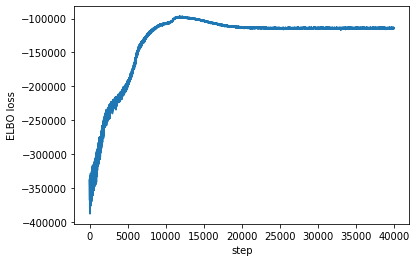

In [35]:
import matplotlib.pyplot as plt

plt.plot(losses[5000:])
plt.xlabel("step")
plt.ylabel("ELBO loss")

Text(0, 0.5, 'ELBO loss')

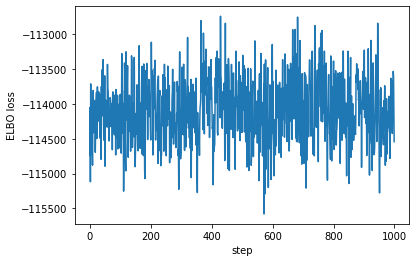

In [36]:
plt.plot(losses[-1000:])
plt.xlabel("step")
plt.ylabel("ELBO loss")

In [37]:
for key, value in pyro.get_param_store().items():    
    print(f"{key}:\n{value}\n")

AutoDiagonalNormal.loc:
Parameter containing:
tensor([-3.3582, -2.4579,  4.0136,  ...,  0.0193, -1.5875, -0.0677],
       requires_grad=True)

AutoDiagonalNormal.scale:
tensor([0.4585, 0.3853, 0.6131,  ..., 0.0104, 0.0066, 0.0123],
       grad_fn=<AddBackward0>)



In [0]:
"""
Be Careful running this - unless needed
"""
ELBO_SAMPLES = 100
NUM_STEPS = 300
# set more elbo samples at once
guide = autoguide.AutoDiagonalNormal(model)
optimiser = pyro.optim.Adam({"lr": 1e-1})
loss = pyro.infer.JitTraceGraph_ELBO(ELBO_SAMPLES)
svi = pyro.infer.SVI(model, guide, optimiser, loss)

losses2 = np.empty(NUM_STEPS)
pyro.clear_param_store()
start = tm.time()
for step in range(NUM_STEPS):
    losses2[step] = svi.step(data)
    if step % 50 == 0:
        print(f"step: {step:>5}, ELBO loss: {losses[step]:.2f}")
print(f"\nfinished in {tm.time() - start:.2f} seconds")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TracerWarning: torch.tensor results are registered as constants in the trace. Y

step:     0, ELBO loss: -8925713793024.00
step:    50, ELBO loss: -17440139264.00
step:   100, ELBO loss: -11420284928.00
step:   150, ELBO loss: -4554721792.00
step:   200, ELBO loss: -3591931136.00
step:   250, ELBO loss: -3198023168.00

finished in 170.85 seconds


In [0]:
samples_dic = Predictive(model, guide=guide, num_samples=1000)(data)
Z_hat = samples_dic['Z'].mean(0) 
tau_hat = samples_dic['tau'].mean(0)
sig_hat = samples_dic['sig'].mean(0) 
W1_hat = samples_dic['W1'].mean(0)
W2_hat = samples_dic['W2'].mean(0)

In [39]:
# error
# reconstruct datasets
X_1_hat = torch.mm(W1_hat, Z_hat) # D[0]*N
X_2_hat = torch.mm(W2_hat, Z_hat) # D[1]*N
print("Reconstruction loss on shared components - MSE")
X_1_shared_loss = np.mean((np.transpose(np.matmul(A_1, Z_shared)) - np.transpose(X_1_hat.detach().numpy()))**2)
print("X_1_shared_loss: ", X_1_shared_loss)
X_2_shared_loss = np.mean((np.transpose(np.matmul(A_2, Z_shared)) - np.transpose(X_2_hat.detach().numpy()))**2)
print("X_2_shared_loss: ", X_2_shared_loss)
print("Automatic relevance detection (ARD) ")
print("Large tau == irrelevant latent component for dataset")
print("Sections 4.1, 4.2")
print(tau_hat)
print(sig_hat)

Reconstruction loss on shared components - MSE
X_1_shared_loss:  2.99741229336143
X_2_shared_loss:  0.9158716873293914
Automatic relevance detection (ARD) 
Large tau == irrelevant latent component for dataset
Sections 4.1, 4.2
tensor([[3.7717e-02, 9.2759e-02],
        [6.9364e+01, 2.3951e+00],
        [1.9338e-01, 1.5397e-01],
        [5.8513e+01, 6.2671e+01],
        [6.3812e+01, 5.9711e+01],
        [2.5254e+01, 4.8920e+00],
        [1.2476e+00, 1.0258e+01],
        [4.8217e+01, 5.8378e+01],
        [1.5342e+00, 3.9128e-01],
        [4.8729e+00, 3.2349e+01]], grad_fn=<MeanBackward1>)
tensor([0.5480, 0.4926], grad_fn=<MeanBackward1>)


#### **Explanation:**
- We will be using a process called SVI with ELBO loss to train our model. At a high level, each step in the training process will take one pass through the model and incorporate the observed data. Then, it will go through the model code again, replacing each pyro.sample statement with the corresponding statement from the guide. 
- It compares the resulting distributions from the model and guide and adjusts the pyro.param values in order to get the guide closer to the model. This way, the guide will in theory follow the model around and get close enough to confidently approximate it.

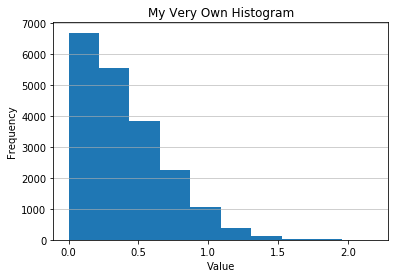

In [0]:
import matplotlib.pyplot as plt
# plot
def visual_(input_sample):
  # An "interface" to matplotlib.axes.Axes.hist() method
  n, bins, patches = plt.hist(x=input_sample, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.title('My Very Own Histogram')
  maxfreq = n.max()
  # Set a clean upper y-axis limit.
  plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# First some visualization for different kinds of distributions
# HalfNormal distribution
sample = pyro.sample("sample", dist.HalfNormal(0.5).expand([20000]))
plt.hist(sample.numpy())
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.show()

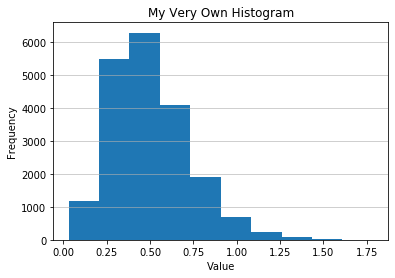

In [0]:
# Gamma distribution
sample2 = pyro.sample("sample2", dist.Gamma(5., 10.).expand([20000]))
plt.hist(sample2.numpy())
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.show()

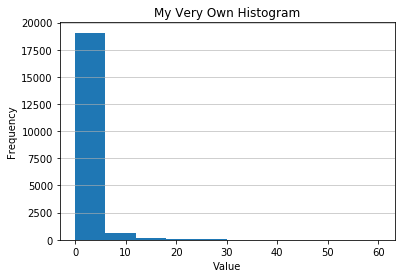

In [0]:
# Gamma distribution - defined in the model - alpha == beta == 0.1
sample3 = pyro.sample("sample3", dist.Gamma(0.1, 0.1).expand([20000]))
plt.hist(sample3.numpy())
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.show()

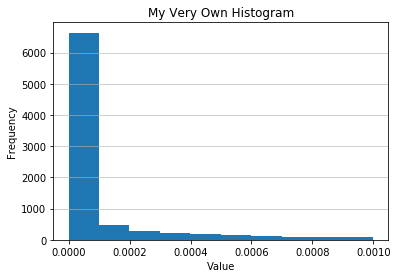

In [0]:
# sub samples visualization in model
sub_sample3 = [i for i in sample3.numpy().tolist() if i < 0.001]
plt.hist(sub_sample3)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.show()

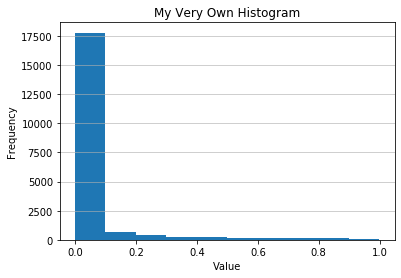

In [0]:
# Beta distribution
sample4 = pyro.sample("sample4", dist.Beta(0.05, 1.).expand([20000]))
plt.hist(sample4.numpy())
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.show()

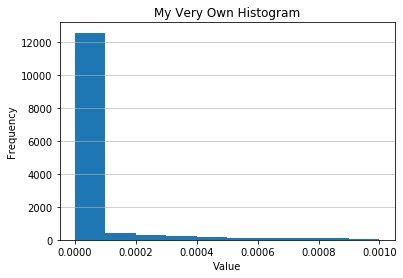

In [0]:
sub_sample4 = [i for i in sample4.numpy().tolist() if i < 0.001]
plt.hist(sub_sample4)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.show()

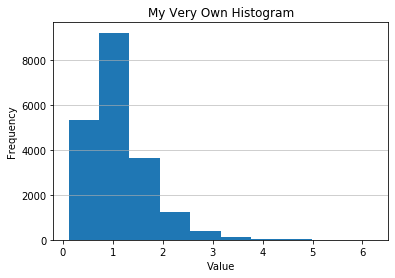

In [0]:
# Normal distribution
sample5 = pyro.sample("sample5", dist.LogNormal(-0.01, 0.5).expand([20000]))
plt.hist(sample5.numpy())
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.show()

In [0]:
# AutoDiagonalNormal: use the mean-field Gaussian variational family to approximate the posterior. 
# http://docs.pyro.ai/en/0.3.0-release/contrib.autoguide.html?highlight=AutoDiagonalNormal#autodiagonalnormal
# This implementation of AutoContinuous uses a Normal distribution with 
# a diagonal covariance matrix to construct a guide over the entire latent space. 
# The guide does not depend on the model’s *args, **kwargs.

# By default the mean vector is initialized to zero and the scale is initialized to the identity. 
# To change this default behavior the user should call pyro.param() before beginning inference, e.g.:
"""
latent_dim = 10
pyro.param("auto_loc", torch.randn(latent_dim))
pyro.param("auto_scale", torch.ones(latent_dim), constraint=constraints.positive)
"""

#### **Estimation of self-specified guide function**

In [40]:
# self-defined distributions sample
from pyro.distributions import Uniform
from pyro.distributions.torch import TransformedDistribution
from pyro.distributions.transforms import SigmoidTransform, AffineTransform, AbsTransform

# But AbsTransform still has problems with log_prob calculation
def Logistic(a,b):
    return TransformedDistribution(Uniform(0, 1), [SigmoidTransform().inv])
Logistic_sample = pyro.sample('Logistic_sample', Logistic(torch.ones(1), torch.ones(1)))
print(Logistic_sample)

def abs_normal(a,b):
   return TransformedDistribution(Normal(a,b), [AbsTransform()])
abs_normal_test = pyro.sample('abs_normal_test', abs_normal(torch.ones(1), torch.ones(1)))
abs_normal_test

tensor(4.5757)


tensor([2.6318])

In [0]:
# performed some good Pyro hygiene
pyro.enable_validation(True)
pyro.clear_param_store()

In [0]:
# Guide here for generating samples through updated parameters
# Every pyro.sample statement without the obs keyword that appears in the model must have a corresponding pyro.sample statement with the same name in the guide
# Note: the sample statements in the model and guide are not required to use the same distribution, but they often do
def guide(data):

  # parameters contained: (tau, sig, Z, W)
  # register variational parameters with Pyro.
  # Constraints ensure facts always remain true during optimization
  interval_range = constraints.interval(-3.0, 3.0)
  valid_range = constraints.greater_than(0.0)

  # positive Gamma distribution parameters
  # torch.distributions.constraints.positive
  tau_alpha = pyro.param("tau_alpha", torch.tensor(3.)) # positive
  tau_beta = pyro.param("tau_beta", torch.tensor(1.), constraint=valid_range) # positive
  tau_q = pyro.sample('tau', dist.LogNormal(tau_alpha, tau_beta).expand([K, 2]).independent(2))

  # real/positive Cauchy distribution location/scale parameters
  sig_location = pyro.param("sig_location", torch.tensor(3.)) # positive
  sig_scale = pyro.param("sig_scale", torch.tensor(1.), constraint=valid_range) # positive 
  pyro.sample('sig', dist.LogNormal(sig_location, sig_scale).expand([2]).independent(1))

  Z_mean = pyro.param("Z_mean", torch.tensor(0.0))
  Z_var = pyro.param("Z_var", torch.tensor(1.0), constraint=valid_range) # positive
  pyro.sample("Z", dist.Normal(Z_mean, Z_var).expand([K, N]).independent(2)) # batch_shape == (K, N)

  W1_mean = pyro.param("W1_mean", torch.tensor(0.0))
  W2_mean = pyro.param("W2_mean", torch.tensor(0.0))
  pyro.sample("W1", dist.Normal(W1_mean, tau_q[:, 0].sqrt().reciprocal()).expand_by([D[0]]).independent(2)) # D[0]*K
  pyro.sample("W2", dist.Normal(W2_mean, tau_q[:, 1].sqrt().reciprocal()).expand_by([D[1]]).independent(2)) # D[1]*K

In [0]:
# relax and allow for more parameters
def guide_flexible(data):
  valid_range = constraints.greater_than(0.0)
  tau_alpha = pyro.param("tau_alpha", torch.tensor(0.).expand([K, 2])) # positive
  tau_beta = pyro.param("tau_beta", torch.tensor(1.).expand([K, 2]), constraint=valid_range) # positive
  tau_q = pyro.sample('tau', dist.LogNormal(tau_alpha, tau_beta).independent(2))

  # real/positive Cauchy distribution location/scale parameters
  sig_location = pyro.param("sig_location", torch.tensor(0.).expand([2])) # positive
  sig_scale = pyro.param("sig_scale", torch.tensor(1.).expand([2]), constraint=valid_range) # positive 
  pyro.sample('sig', dist.LogNormal(sig_location, sig_scale).independent(1))

  Z_mean = pyro.param("Z_mean", torch.tensor(0.0).expand([K, N]))
  Z_var = pyro.param("Z_var", torch.tensor(1.0).expand([K, N]), constraint=valid_range) # positive
  pyro.sample("Z", dist.Normal(Z_mean, Z_var).independent(2)) # batch_shape == (K, N)

  W1_mean = pyro.param("W1_mean", torch.tensor(0.0).expand([D[0], K]))
  W2_mean = pyro.param("W2_mean", torch.tensor(0.0).expand([D[1], K]))
  pyro.sample("W1", dist.Normal(W1_mean, tau_q[:, 0].sqrt().reciprocal()).independent(2)) # D[0]*K
  pyro.sample("W2", dist.Normal(W2_mean, tau_q[:, 1].sqrt().reciprocal()).independent(2)) # D[1]*K

In [46]:
# Training using self-specified guide function
# Replay Passenger replace the sample sites value but fun for log_prob calculation still follows separately
# It achieves A distribution estimating B distribution
# setup the optimizer

# Adam Beta tuning parameters: 
# https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c

n_steps = 15000
adam_params = {"lr":1e-2, "betas": (0.9, 0.999)}
optimizer = Adam(adam_params)
# setup the inference algorithm
svi = SVI(model, guide_flexible, optimizer, loss=Trace_ELBO())

data = torch.tensor(data)
for step_ in range(n_steps+1):
  loss = svi.step(data)
  # calculate the loss and take a gradient step
  if step_ % 1000 == 0:
    # print(pyro.param("tau_alpha"))
    # print(pyro.param("tau_beta"))
    # print(pyro.param("sig_location"))
    # print(pyro.param("sig_scale"))
    # print(pyro.param("Z_var"))
    print("[iteration %04d] loss: %.4f" % (step_ + 1, loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[iteration 0001] loss: 4783668.6533
[iteration 1001] loss: 161239.5113
[iteration 2001] loss: 95185.8309
[iteration 3001] loss: 90128.1617
[iteration 4001] loss: 84947.5202
[iteration 5001] loss: 82391.3975
[iteration 6001] loss: 75854.9607
[iteration 7001] loss: 73105.9576
[iteration 8001] loss: 68862.3710
[iteration 9001] loss: 72648.7790
[iteration 10001] loss: 66706.2228
[iteration 11001] loss: 65755.3593
[iteration 12001] loss: 66159.2829
[iteration 13001] loss: 65261.6117
[iteration 14001] loss: 65379.4244
[iteration 15001] loss: 65391.1529


In [47]:
# see all estimated parameters finally
positive_list = ["tau_beta", "sig_scale", "Z_var"]
for name, value in pyro.get_param_store().named_parameters():
  print(name)
  # turn into exp.form in needed
  if name in positive_list:
    print(value.exp())
  else:
    print(value)

tau_alpha
tensor([[2.3638, 2.9336],
        [5.5133, 5.9087],
        [5.4913, 5.8818],
        [4.6125, 5.6425],
        [5.5140, 5.8254],
        [5.1064, 4.9676],
        [2.7156, 2.7290],
        [2.2870, 2.5729],
        [3.4555, 5.4377],
        [5.4979, 4.3794]], requires_grad=True)
tau_beta
tensor([[0.0287, 0.0319],
        [0.1996, 0.1334],
        [0.1553, 0.1412],
        [0.0974, 0.1062],
        [0.1569, 0.1277],
        [0.1071, 0.0772],
        [0.0322, 0.0220],
        [0.0292, 0.0160],
        [0.0529, 0.1056],
        [0.1391, 0.0553]], grad_fn=<ExpBackward>)
sig_location
tensor([-0.0137, -0.2589], requires_grad=True)
sig_scale
tensor([0.0729, 0.0450], grad_fn=<ExpBackward>)
Z_mean
tensor([[ 1.2066,  1.2980,  1.5824,  ...,  0.9344,  0.2733, -0.0341],
        [-0.0941, -0.0630, -0.0142,  ...,  0.0959,  0.0469, -0.0853],
        [ 0.1553, -0.0193,  0.1892,  ..., -0.1073,  0.0564,  0.0519],
        ...,
        [-0.4997, -0.0211,  0.2986,  ..., -0.4895, -2.0533, -2.5964]

In [0]:
samples_dic = Predictive(model, guide=guide_flexible, num_samples=1000)(data)
Z_hat = samples_dic['Z'].mean(0) 
tau_hat = samples_dic['tau'].mean(0)
sig_hat = samples_dic['sig'].mean(0) 
W1_hat = samples_dic['W1'].mean(0)
W2_hat = samples_dic['W2'].mean(0)

In [50]:
# error
# reconstruct datasets
X_1_hat = torch.mm(W1_hat, Z_hat) # D[0]*N
X_2_hat = torch.mm(W2_hat, Z_hat) # D[1]*N
print("Reconstruction loss on shared components - MSE")
X_1_shared_loss = np.mean((np.transpose(np.matmul(A_1, Z_shared)) - np.transpose(X_1_hat.detach().numpy()))**2)
print("X_1_shared_loss: ", X_1_shared_loss)
X_2_shared_loss = np.mean((np.transpose(np.matmul(A_2, Z_shared)) - np.transpose(X_2_hat.detach().numpy()))**2)
print("X_2_shared_loss: ", X_2_shared_loss)
print("Automatic relevance detection (ARD) ")
print("Large tau == irrelevant latent component for dataset")
print("Sections 4.1, 4.2")
print(tau_hat)
print(sig_hat)

Reconstruction loss on shared components - MSE
X_1_shared_loss:  2.522005911743572
X_2_shared_loss:  0.6966023017529834
Automatic relevance detection (ARD) 
Large tau == irrelevant latent component for dataset
Sections 4.1, 4.2
tensor([[ 10.6384,  18.8178],
        [254.5573, 372.2515],
        [246.2997, 363.6180],
        [101.5163, 284.1147],
        [252.3111, 339.3556],
        [166.2630, 143.9878],
        [ 15.1464,  15.3283],
        [  9.8555,  13.1072],
        [ 31.6210, 231.3800],
        [245.4028,  80.0069]], grad_fn=<MeanBackward1>)
tensor([0.9893, 0.7712], grad_fn=<MeanBackward1>)


#### **A good completed example for reference:**
- https://medium.com/paper-club/understanding-pyros-model-and-guide-a-love-story-7f3aa0603886

In [0]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [0]:
pyro.enable_validation(True)
pyro.clear_param_store()

In [0]:
data = torch.cat((torch.zeros(9), torch.ones(7), torch.empty(4).fill_(2.)))
data

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
        2., 2.])

In [0]:
def model(data):
  alpha = torch.tensor(6.0)
  beta = torch.tensor(10.0)
  pay_probs = pyro.sample('pay_probs', dist.Beta(alpha, beta).expand([3]).independent(1)) # batch 3
  normalized_pay_probs = pay_probs / torch.sum(pay_probs)

  with pyro.iarange('data_loop', len(data)):
    pyro.sample('obs', dist.Categorical(probs=normalized_pay_probs), obs=data)

In [0]:
def guide(data):
  alphas = pyro.param('alphas', torch.tensor(6.).expand([3]), constraint=torch.distributions.constraints.positive) # batch 3
  betas = pyro.param('betas', torch.tensor(10.).expand([3]), constraint=torch.distributions.constraints.positive) # batch 3
  pyro.sample('pay_probs', dist.Beta(alphas, betas).independent(1)) # batch 3

In [0]:
def print_progress():
  alphas = pyro.param("alphas")
  betas = pyro.param("betas")
  
  # if torch.cuda.is_available():
  #   alphas.cuda()
  #   betas.cuda()

  means = alphas / (alphas + betas)
  normalized_means = means / torch.sum(means)
  factors = betas / (alphas * (1.0 + alphas + betas))
  stdevs = normalized_means * torch.sqrt(factors)

  tiger_pays_string = "probability Tiger pays: {0:.3f} +/- {1:.2f}".format(normalized_means[0], stdevs[0])
  jason_pays_string = "probability Jason pays: {0:.3f} +/- {1:.2f}".format(normalized_means[1], stdevs[1])
  james_pays_string = "probability James pays: {0:.3f} +/- {1:.2f}".format(normalized_means[2], stdevs[2])
  print("[", step_, "|", tiger_pays_string, "|", jason_pays_string, "|", james_pays_string, "]")

In [0]:
adam_params = {"lr": 0.0005}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

n_steps = 100
for step_ in range(n_steps):
  print(step_)
  svi.step(data)
  if step_ % 20 == 0:
    print_progress()

In [0]:
from pyro.infer import Predictive
torch.mean(Predictive(model, guide=guide, num_samples=4)(data)['pay_probs'], dim=0)
Predictive(model, guide=guide, num_samples=4)(data)['pay_probs']

tensor([[[0.3915, 0.3195, 0.5791]],

        [[0.4693, 0.4703, 0.1952]],

        [[0.7312, 0.1591, 0.2843]],

        [[0.3687, 0.3234, 0.3297]]], grad_fn=<ViewBackward>)

In [0]:
Predictive(model, guide=guide, num_samples=4)(data)['pay_probs'].mean(0)

tensor([[0.3310, 0.3325, 0.4196]], grad_fn=<MeanBackward1>)

In [0]:
Predictive(model, guide=guide, num_samples=1)(data)

{'obs': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
          2., 2.]]),
 'pay_probs': tensor([[[0.5444, 0.5338, 0.4234]]], grad_fn=<ViewBackward>)}

In [0]:
# see all estimated parameters finally
for name, value in pyro.get_param_store().named_parameters():
  print(name)
  print(value)

alphas
tensor([1.8152, 1.7964, 1.7697], requires_grad=True)
betas
tensor([2.2763, 2.3005, 2.3238], requires_grad=True)


#### **Another good example for detailed operations:**
  - http://willcrichton.net/notes/probabilistic-programming-under-the-hood/

In [0]:
import pyro.distributions as dist
from pyro import sample
from torch import tensor

# A probability distribution has two key functions: 
# sample, which returns a single value in accordance with its probability (e.g. 0 and 1 are equally likely from the coin flip), 
# log_prob, which returns the log probability of a sample under the model.

# A fair coin
coinflip = sample("coinflip", dist.Bernoulli(probs=0.5))
# e.g. coinflip == tensor(0.)

# A noisy sample
noisy_sample = sample("noisy_sample", dist.Normal(loc=0, scale=1))
# e.g. noisy_sample == tensor(0.35)

print(dist.Bernoulli(0.5).log_prob(tensor(0.)).exp()) # 0.5000
print(dist.Normal(0, 1).log_prob(tensor(0.35)).exp()) # 0.3752

tensor(0.5000)
tensor(0.3752)


In [0]:
# This model below generates a single data point by running the function top to bottom as a normal program.
# This is called a “generative” model because it has an explicit probabilistic model for every random variable (e.g. the prior on feeling_lazy). 
# By contrast, a “discriminative” model only tries to model a conditional probabilistic distribution, 
# where given some observations, you predict the distribution over unobserved variables.
def sleep_model():
    # Very likely to feel lazy
    feeling_lazy = sample("feeling_lazy", dist.Bernoulli(0.9))
    if feeling_lazy:
        # Only going to (possibly) ignore my alarm if I'm feeling lazy
        ignore_alarm = sample("ignore_alarm", dist.Bernoulli(0.8))
        # Will sleep more if I ignore my alarm
        amount_slept = sample("amount_slept", dist.Normal(8+2*ignore_alarm, 1))
    else:
        amount_slept = sample("amount_slept", dist.Normal(6, 1))
    return amount_slept
sleep_model() # e.g. 9.8280

tensor(9.5660)

In [0]:
# Implement one of these distributions
from random import random
class Bernoulli:
    def __init__(self, p):
        self.p = p
    def sample(self):
        if random() < self.p:
            return tensor(1.)
        else:
            return tensor(0.)
    def log_prob(self, x):
        return (x * self.p + (1 - x) * (1 - self.p)).log()

b = Bernoulli(0.8)
b.sample() # e.g. 0.
b.log_prob(tensor(0.)).exp() # 0.2

tensor(0.2000)

In [0]:
from pyro.poutine import trace
from pprint import pprint

# Runs the sleep model once and collects a trace
# trace feature will collect values every time they are sampled with sample 
# and store them with the corresponding string name
tr = trace(sleep_model).get_trace()

pprint({
    name: {
        'value': props['value'],
        'prob': props['fn'].log_prob(props['value']).exp()
    }
    for (name, props) in tr.nodes.items()
    if props['type'] == 'sample'
})
# {'amount_slept': {'prob': tensor(0.0799), 'value': tensor(8.2069)},
#  'feeling_lazy': {'prob': tensor(0.9000), 'value': tensor(1.)},
#  'ignore_alarm': {'prob': tensor(0.8000), 'value': tensor(1.)}}

# the joint probability of the entire trace
print(tr.log_prob_sum().exp()) # 0.0575

{'amount_slept': {'prob': tensor(0.3971), 'value': tensor(5.9041)},
 'feeling_lazy': {'prob': tensor(0.1000), 'value': tensor(0.)}}
tensor(0.0397)


In [0]:
# The code above randomly generates a trace and shows its probability, 
# but we want to compute the probability of a pre-selected set of values. For that, we can use condition:
from pyro import condition

# condition means “force the sample to return the provided value, 
# and compute the trace probability as if that value was sampled.
cond_model = condition(sleep_model, {
    "feeling_lazy": tensor(1.),
    "ignore_alarm": tensor(0.),
    "amount_slept": tensor(10.)
})
trace(cond_model).get_trace().log_prob_sum().exp() # 0.0097

tensor(0.0097)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9e40e160>,
      dtype=object)

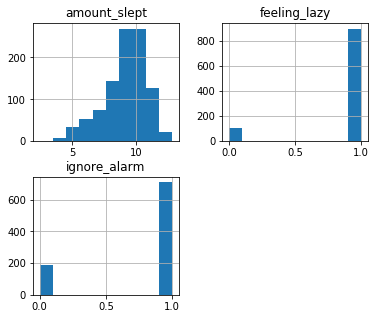

In [0]:
# Now, we can produce an approximate answer to any of our questions above by sampling from the distribution enough times. 
# For example, we can look at the marginal distribution over each variable:
import pandas as pd
import matplotlib.pyplot as plt

traces = []
for _ in range(1000):
    tr = trace(sleep_model).get_trace()
    values = {
        name: props['value'].item()
        for (name, props) in tr.nodes.items()
        if props['type'] == 'sample'
    }
    traces.append(values)

pd.DataFrame(traces).hist(figsize=(6, 5))

#### **Quick Sampling and Variational Inference review**
- Stanford Sampling notes: https://ermongroup.github.io/cs228-notes/inference/sampling/
  - produce answers by repeatedly generating random numbers from a distribution of interest.
    - Sampling from a probability distribution
    - Forward Sampling
      - We start by sampling the variables with no parents; then we sample from the next generation by conditioning these variables’ CPDs to values sampled at the first step. We proceed like this until all n variables have been sampled.
    - Monte Carlo estimation
    - Rejection sampling
    - Importance sampling
    - Normalized importance sampling
    - Markov chain Monte Carlo
      - the idea of MCMC algorithms is to construct a Markov chain over the assignments to a probability function p; the chain will have a stationary distribution equal to p itself; by running the chain for some number of time, we will sample from p.
      - At a high level, MCMC algorithms will have the following structure. They take as argument a transition operator T specifying a Markov chain whose stationary distribution is p, and an initial assignment x0 to the variables of p. An MCMC algorithm then perform the following steps. (1) Run the Markov chain from x0 for B burn-in steps. (2) Run the Markov chain for N sampling steps and collect all the states that it visits. Assuming B is sufficiently large, the latter collection of states will form samples from p. 
      - We may then use these samples for Monte Carlo integration (or in importance sampling). We may also use them to produce Monte Carlo estimates of marginal probabilities. Finally, we may take the sample with the highest probability and use it as an estimate of the mode (i.e. perform MAP inference).
    - Metropolis-Hastings algorithm
      - Gibbs sampling: (special case of MH algorithm) both Gibbs sampling and MH will eventually produce samples from their stationary distribution, which by construction is P.
    - Running time of MCMC
      - A key parameter to this algorithm in the number of burn-in steps B. Intuitively, this corresponds to the number of steps needed to converge to our limit (stationary) distribution. This is called the mixing time of the Markov chain.
- Stanford Variational Inference: https://ermongroup.github.io/cs228-notes/inference/variational/
  - shortcomings of sampling: Although they are guaranteed to find a globally optimal solution given enough time, it is difficult to tell how close they are to a good solution given the finite amount of time that they have in practice. In order to quickly reach a good solution, MCMC methods require choosing an appropriate sampling technique (e.g. a good proposal in Metropolis-Hastings). Choosing this technique can be an art in itself.
  - TARGET: solve an optimization problem over a class of tractable distributions Q in order to find a q∈Q that is most similar to p. We will then query q (rather than p) in order to get an approximate solution.
  - Compare: variational approaches will almost never find the globally optimal solution. We will even have bounds on their accuracy. They are more amenable to techniques like stochastic gradient optimization, parallelization over multiple processors, and acceleration using GPUs.
  - Kullback-Leibler divergence
  - Variational lower bound
  - Choice of KL divergence
  - Mean-field inference



#### **CONTINUE: Another good example for detailed operations:**
- **Variational inference 1: autodifferentiation**

In [0]:
# Since Pyro’s stake in the ground is on variational inference, let’s explore all the mechanics underneath it. 
# For starters, we need to understand autodifferentiation, gradients, and backpropagation in PyTorch. 
# Let’s say I have an extremely simple model that just samples a normal distribution with fixed parameters:
norm = dist.Normal(0, 1)
x = sample("x", norm)
print(x)

from pyro import param

# A parameter is a persistent value linked to a string name with an initial value here of 0. 
# (It’s a Torch tensor with requires_grad=True.) 
mu = param("mu", tensor(0.))
norm = dist.Normal(mu, 1)
x = sample("x", norm)
print(x)

tensor(-2.0690)
tensor(1.7973, grad_fn=<AddBackward0>)


In [0]:
# Our goal is to update mu such that the probability of the value 5 under the normal distribution norm is maximized. PyTorch makes that quite easy:
prob = norm.log_prob(torch.tensor(5))
print(prob, prob.exp()) # -13.4189, 0.000002

# The magic happens with prob.backward(). 
# This essentially says: for each variable involved in computing the log probability, 
# compute a delta (gradient) such that if moved by that delta, the log probability would increase. 
# In this case, the gradient of 5 is the optimal solution to maximizing the probability of 5 under the model N(5,1), which has probability of 0.3989 as shown.
prob.backward() # Compute gradients with respect to probability

print(mu)      # 0.0
print(mu.grad) # 5.0
mu.data += mu.grad # Manually take gradient step

print(dist.Normal(mu, 1).log_prob(torch.tensor(5))) # 0.3989

tensor(-13.4189, grad_fn=<SubBackward0>) tensor(1.4867e-06, grad_fn=<ExpBackward>)
tensor(0., requires_grad=True)
tensor(5.)
tensor(-0.9189, grad_fn=<SubBackward0>)


In [0]:
dist.Normal(mu, 1).log_prob(torch.tensor(5)).exp()

tensor(0.3989, grad_fn=<ExpBackward>)

In [0]:
# Generalization version
def model():
    mu = pyro.param("mu", torch.tensor(0.))
    return pyro.sample("x", dist.Normal(mu, torch.tensor(1.)))

# When we condition the model, this asserts that x = 5 and adds N(mu, 1).log_prob(5) to the trace’s probability. 
# Then running backpropagation will change the gradient on mu accordingly. 
cond_model = condition(model, {"x": torch.tensor(5.)})
tr = trace(cond_model).get_trace()
# This formulation is more general in that every sample location can contribute to the final log probability, 
# and each parameter will be differentiated with respect to sum of all contributions.
tr.log_prob_sum().backward()
mu = param("mu")
mu.data += mu.grad

# # The only remaining issue is the manual gradient steps. We currently both have to identify which parameters need to be updated, 
# and then explicitly step them. PyTorch has a wide array of optimization algorithms that can do this for us, so we can just pick a common one like Adam.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9dd3a4a8>,
      dtype=object)

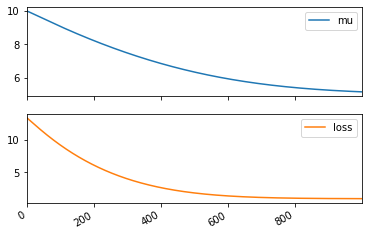

In [0]:
from torch.optim import Adam

def model():
    mu = param("mu", tensor(0.))
    return sample("x", dist.Normal(mu, 1))

model() # Instantiate the mu parameter
cond_model = condition(model, {"x": torch.tensor(5.)})

# Large learning rate for demonstration purposes
optimizer = Adam([param("mu")], lr=0.01)
mus = []
losses = []
for _ in range(1000):
    tr = trace(cond_model).get_trace()
    # Optimizer wants to push positive values towards zero,
    # so use negative log probability
    prob = -tr.log_prob_sum()
    prob.backward()
    # Update parameters according to optimization strategy
    optimizer.step()
    # Zero all parameter gradients so they don't accumulate
    optimizer.zero_grad()
    # Record probability (or "loss") along with current mu
    losses.append(prob.item())
    mus.append(param("mu").item())
pd.DataFrame({"mu": mus, "loss": losses}).plot(subplots=True)

- **Variational inference 2: guide functions**

In [0]:
# For variational inference, the key idea is that we’re going to use a separate function from the model called the “guide” to represent the posterior. 
# The guide is a stochastic function that represents a probability distribution over the latent (unobserved) variables. For example, this is a valid guide:
def sleep_guide():
  sample("feeling_lazy", dist.Gamma(1., 1.))
  sample("ignore_alarm", dist.Gamma(1., 1.))

trace(sleep_guide).get_trace().nodes['feeling_lazy']['value'] # 1.

tensor(0.1452)

In [0]:
import torch 
def elbo(guide, cond_model):
  dist = 0.
  for fl in [0., 1.]:
    for ia in [0., 1.] if fl == 1. else [0.]:
      log_prob = lambda f: trace(condition(
        f, {"feeling_lazy": tensor(fl), "ignore_alarm": tensor(ia)})).get_trace().log_prob_sum()
      guide_prob = log_prob(guide)
      cond_model_prob = log_prob(cond_model)
      term = guide_prob.exp() * (cond_model_prob - guide_prob)
      if not torch.isnan(term):
        dist += term
  return dist

elbo(sleep_guide, underslept) # -4.63

- **Variational inference 3: ELBO optimization**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9dd15710>,
      dtype=object)

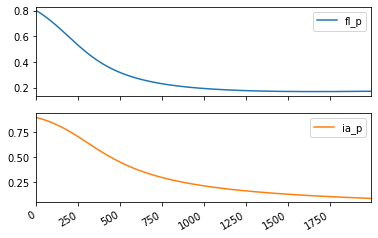

In [0]:
import pyro
import torch.distributions.constraints as constraints

pyro.clear_param_store()

def sleep_guide():
    # Constraints ensure facts always remain true during optimization,
    # e.g. that the parameter of a Bernoulli is always between 0 and 1
    valid_prob = constraints.interval(0., 1.)
    fl_p = param('fl_p', tensor(0.8), constraint=valid_prob)
    ia_p = param('ia_p', tensor(0.9), constraint=valid_prob)
    feeling_lazy = sample('feeling_lazy', dist.Bernoulli(fl_p))

    # Consistent with the model, we only sample ignore_alarm if
    # feeling_lazy is true
    if feeling_lazy == 1.:
      sample('ignore_alarm', dist.Bernoulli(ia_p))
sleep_guide()

adam = Adam([param('fl_p').unconstrained(), param('ia_p').unconstrained()],lr=0.005, betas=(0.90, 0.999))
param_vals = []

for _ in range(2000):
    # We can use our elbo function from earlier and compute its gradient
    loss = -elbo(sleep_guide, underslept)
    loss.backward()

    adam.step()
    adam.zero_grad()
    param_vals.append({k: param(k).item() for k in ['fl_p', 'ia_p']})

pd.DataFrame(param_vals).plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9db9aeb8>,
      dtype=object)

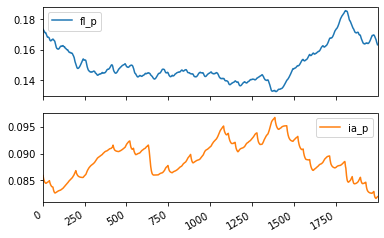

In [0]:
from pyro.poutine import replay

def elbo_approx(guide, cond_model):
    guide_trace = trace(guide).get_trace()
    model_trace = trace(replay(cond_model, guide_trace)).get_trace()
    return model_trace.log_prob_sum() - guide_trace.log_prob_sum()

param_vals = []
for _ in range(2000):
    loss = -elbo_approx(sleep_guide, underslept)
    loss.backward()
    adam.step()
    adam.zero_grad()
    param_vals.append({k: param(k).item() for k in ['fl_p', 'ia_p']})

pd.DataFrame(param_vals).plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9dad3ef0>,
      dtype=object)

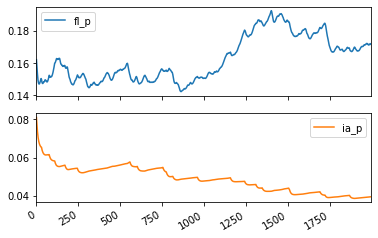

In [0]:
def elbo_better_approx(guide, cond_model):
    guide_trace = trace(guide).get_trace()
    model_trace = trace(replay(cond_model, guide_trace)).get_trace()
    elbo = model_trace.log_prob_sum() - guide_trace.log_prob_sum()
    # "detach" means "don't compute gradients through this expression"
    return guide_trace.log_prob_sum() * elbo.detach() + elbo

param_vals = []
for _ in range(2000):
    loss = -elbo_better_approx(sleep_guide, underslept)
    loss.backward()
    adam.step()
    adam.zero_grad()
    param_vals.append({k: param(k).item() for k in ['fl_p', 'ia_p']})

pd.DataFrame(param_vals).plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d9d81dcc0>,
      dtype=object)

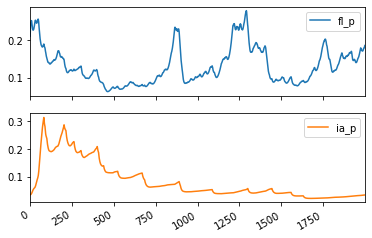

In [0]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

adam = Adam({"lr": 0.05})
svi = SVI(underslept, sleep_guide, adam, loss=Trace_ELBO())

param_vals = []
for _ in range(2000):
    svi.step()
    param_vals.append({k: param(k).item() for k in ["fl_p", "ia_p"]})

pd.DataFrame(param_vals).plot(subplots=True)